TROVO LE POSIZIONI DELLE FOGLI E PER CIASCUN NEURONE DI CIASCUNA AREA


In [1]:
import numpy as np
import pandas as pd
import requests
import os
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ks_2samp
import pickle
import networkx as nx
from scipy.spatial import distance
import community as community_louvain
from tqdm import tqdm
import time

In [2]:
with open('/content/drive/MyDrive/Progetto DSN/Analysis_Data/area_data.pkl', 'rb') as file:
    loaded_data = pickle.load(file)

# Ora puoi accedere ai dati caricati
VISp = loaded_data['VISp']
VISal = loaded_data['VISal']
SSp_bfd = loaded_data['SSp_bfd']

In [3]:
def get_leaf_coordinates(neuron_df):
    # Trova gli indici dei nodi che non compaiono nella colonna "Parent Node Index"
    leaf_indices = set(neuron_df['Node Index']) - set(neuron_df['Parent Node Index'])

    # Ottieni le coordinate delle foglie
    leaf_coordinates = neuron_df[neuron_df['Node Index'].isin(leaf_indices)][['X Coordinate', 'Y Coordinate', 'Z Coordinate']].values

    # Restituisci la lista delle coordinate delle foglie
    return leaf_coordinates#.tolist()

# Esempio di utilizzo con i tuoi dati
leaf_coordinates_VISp = [get_leaf_coordinates(df) for df in VISp]
leaf_coordinates_VISal = [get_leaf_coordinates(df) for df in VISal]
leaf_coordinates_SSp_bfd = [get_leaf_coordinates(df) for df in SSp_bfd]


CREO HEATMAP DALLE COORDINATE DELLE FOGLIE

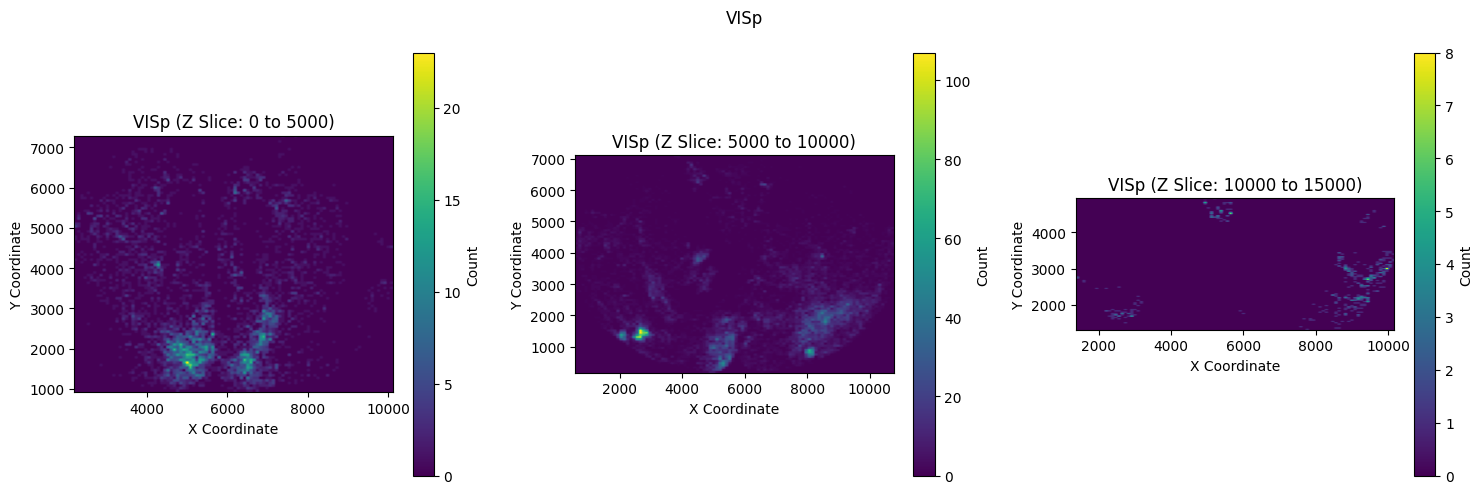

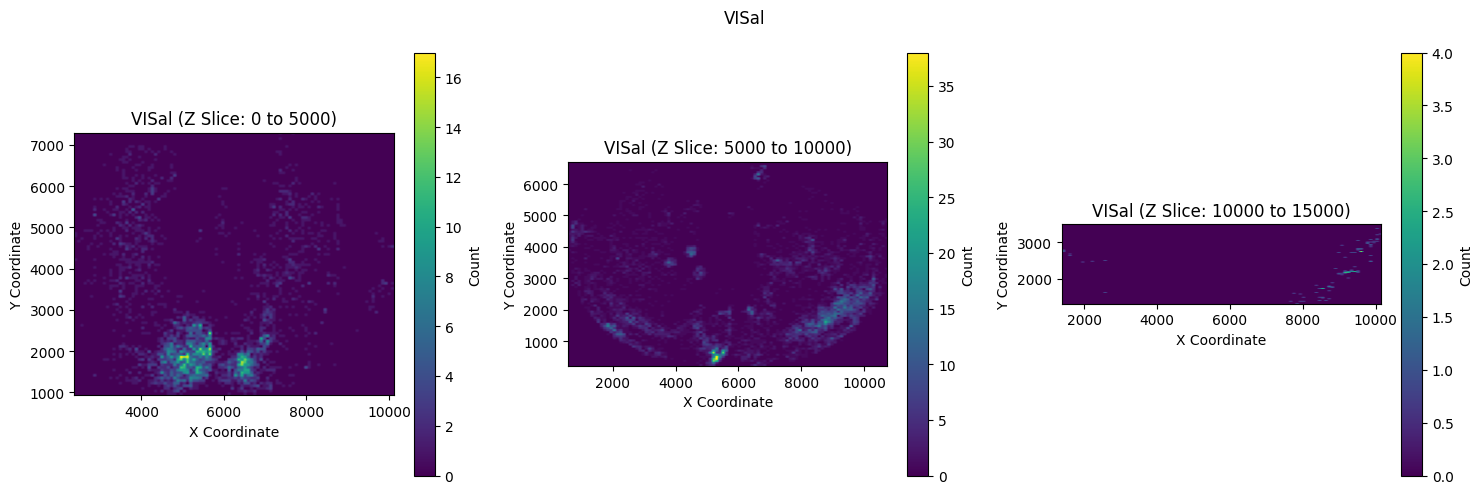

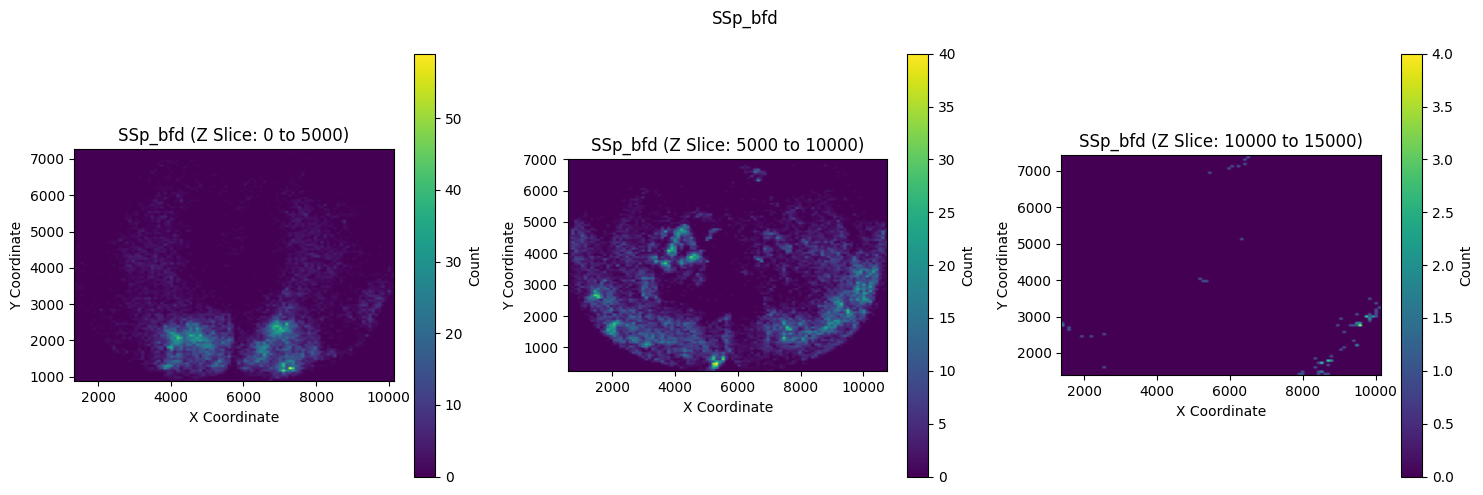

In [4]:

def create_heatmap(ax, leaf_coordinates, title, z_slice):
    all_leaf_coordinates = [coord for sublist in leaf_coordinates for coord in sublist]

    # Estrai le coordinate x, y, z
    x_coords = [coord[0] for coord in all_leaf_coordinates]
    y_coords = [coord[1] for coord in all_leaf_coordinates]
    z_coords = [coord[2] for coord in all_leaf_coordinates]

    if z_slice is not None:
        # Filtra le coordinate in base allo slice lungo l'asse z
        x_coords = [x for x, z in zip(x_coords, z_coords) if z_slice[0] <= z <= z_slice[1]]
        y_coords = [y for y, z in zip(y_coords, z_coords) if z_slice[0] <= z <= z_slice[1]]

    # Crea la heatmap
    heatmap, xedges, yedges = np.histogram2d(x_coords, y_coords, bins=100)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

    im = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='viridis')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    if z_slice is not None:
        ax.set_title(f'{title} (Z Slice: {z_slice[0]} to {z_slice[1]})')
    else:
        ax.set_title(title)

    # Aggiungi la barra laterale per la scala dei colori
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.set_label('Count')  # Modifica l'etichetta della barra laterale

# Crea e visualizza le heatmap per ciascuna area
def create_heatmaps_for_area(leaf_coordinates, area_name):
    # Definisci gli intervalli per gli slice lungo l'asse z
    z_slices = [(0, 5000), (5000, 10000), (10000, 15000)]

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(area_name)

    for ax, z_slice in zip(axs, z_slices):
        create_heatmap(ax, leaf_coordinates, area_name, z_slice)

    plt.tight_layout()
    plt.show()

# Creare e visualizzare le heatmap per ciascuna area
create_heatmaps_for_area(leaf_coordinates_VISp, 'VISp')
create_heatmaps_for_area(leaf_coordinates_VISal, 'VISal')
create_heatmaps_for_area(leaf_coordinates_SSp_bfd, 'SSp_bfd')

ANALISI DEI GRAFI

In [ ]:
# Funzione per creare un grafo da un DataFrame SWC
def create_graph_from_swc(df):
    G = nx.DiGraph()

    # Aggiungi nodi
    for _, row in df.iterrows():
        G.add_node(row['Node Index'], pos=(row['X Coordinate'], row['Y Coordinate'], row['Z Coordinate']), type=row['Type'], radius=row['Radius'])

    # Aggiungi archi (connessioni padre-figlio)
    for _, row in df.iterrows():
        if row['Parent Node Index'] != -1:  # Se non è la radice
            G.add_edge(row['Parent Node Index'], row['Node Index'])
    return G

In [ ]:
G = create_graph_from_swc(VISp[0])

Drawing nodes: 100%|██████████| 11337/11337 [01:23<00:00, 136.32it/s]


Tempo di rendering del grafo: 178.19 secondi


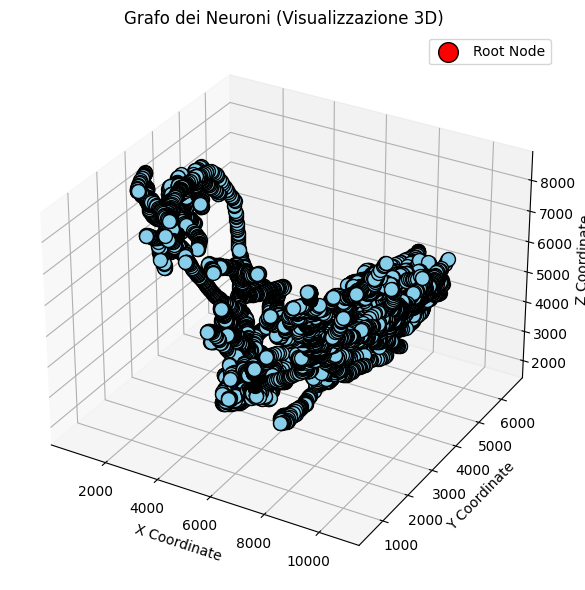

In [ ]:
def draw_3d_graph(G):
    start_time = time.time()  # Inizio del timer

    # Crea una figura 3D
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Estrai le posizioni dei nodi dal grafo
    node_pos = nx.get_node_attributes(G, 'pos')

    # Aggiungi la barra di avanzamento
    with tqdm(total=len(G.nodes()), desc="Drawing nodes") as pbar:
        # Disegna i nodi
        for node, (x, y, z) in node_pos.items():
            if node == 1:
                ax.scatter(x, y, z, color='red', edgecolors='black', s=500, label='Root Node')  # Nodo radice
            else:
                ax.scatter(x, y, z, color='skyblue', edgecolors='black', s=100)  # Altri nodi
            pbar.update(1)  # Aggiorna la barra di avanzamento

    # Disegna gli archi
    for edge in G.edges():
        start = node_pos[edge[0]]
        end = node_pos[edge[1]]
        ax.plot([start[0], end[0]], [start[1], end[1]], [start[2], end[2]], color='black')

    ax.set_title('Grafo dei Neuroni (Visualizzazione 3D)')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_zlabel('Z Coordinate')
    ax.grid(True)
    ax.legend()

    end_time = time.time()  # Fine del timer
    elapsed_time = end_time - start_time  # Calcola il tempo trascorso
    print(f"Tempo di rendering del grafo: {elapsed_time:.2f} secondi")

    plt.tight_layout()
    plt.show()

# Chiamata alla funzione per disegnare il grafo
draw_3d_graph(G)

In [ ]:
# Creazione dei grafi per ogni neurone
VISp_graphs = [create_graph_from_swc(df) for df in VISp]
VISal_graphs = [create_graph_from_swc(df) for df in VISal]
SSp_bfd_graphs = [create_graph_from_swc(df) for df in SSp_bfd]

In [ ]:
# Funzione per calcolare la betweenness di un grafo
def calculate_betweenness(graphs):
    betweenness_results = []
    for G in tqdm(graphs, desc="Calculating betweenness centrality"):
        betweenness = nx.betweenness_centrality(G)
        betweenness_results.append(betweenness)
    return betweenness_results

In [ ]:
# Calcolare la betweenness per ogni area
VISp_betweenness = calculate_betweenness(VISp_graphs)
VISal_betweenness = calculate_betweenness(VISal_graphs)
SSp_bfd_betweenness = calculate_betweenness(SSp_bfd_graphs)

Calculating betweenness centrality: 100%|██████████| 110/110 [10:39:25<00:00, 348.78s/it]


In [ ]:
with open('VISp_betweenness.pkl', 'wb') as f:
    pickle.dump(VISp_betweenness, f)

with open('VISal_betweenness.pkl', 'wb') as f:
    pickle.dump(VISal_betweenness, f)

with open('SSp_bfd_betweenness.pkl', 'wb') as f:
    pickle.dump(SSp_bfd_betweenness, f)

In [ ]:
# Funzione per l'analisi statistica
def analyze_betweenness(betweenness_list, area_name):
    stats = {
        'Mean': [],
        'Std Dev': [],
        'Median': []
    }
    for betweenness in betweenness_list:
        values = list(betweenness.values())
        stats['Mean'].append(pd.Series(values).mean())
        stats['Std Dev'].append(pd.Series(values).std())
        stats['Median'].append(pd.Series(values).median())

    df_stats = pd.DataFrame(stats)
    df_stats.index = [f'Graph {i+1}' for i in range(len(betweenness_list))]
    print(f"Summary statistics for {area_name}:")
    print(df_stats)

    # Boxplot per visualizzare la distribuzione della betweenness
    plt.figure(figsize=(10, 6))
    plt.boxplot([list(betweenness.values()) for betweenness in betweenness_list], labels=[f'Graph {i+1}' for i in range(len(betweenness_list))])
    plt.title(f'Betweenness Centrality Distribution - {area_name}')
    plt.xlabel('Graph')
    plt.ylabel('Betweenness Centrality')
    plt.grid(True)
    plt.show()

Summary statistics for VISp:
              Mean   Std Dev    Median
Graph 1   0.000119  0.000295  0.000025
Graph 2   0.005394  0.007660  0.002176
Graph 3   0.000041  0.000143  0.000007
Graph 4   0.003049  0.007148  0.000220
Graph 5   0.001747  0.004094  0.000154
...            ...       ...       ...
Graph 84  0.001038  0.001217  0.000506
Graph 85  0.003918  0.008021  0.000807
Graph 86  0.000191  0.000403  0.000038
Graph 87  0.000587  0.000650  0.000362
Graph 88  0.000888  0.001329  0.000299

[88 rows x 3 columns]


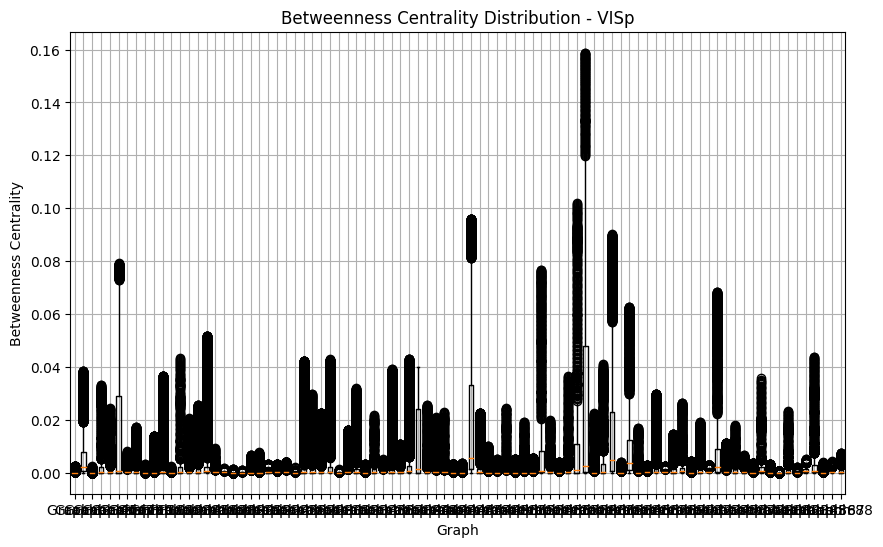

Summary statistics for VISal:
              Mean   Std Dev    Median
Graph 1   0.001976  0.004155  0.000427
Graph 2   0.000498  0.000966  0.000061
Graph 3   0.003276  0.008639  0.000098
Graph 4   0.001484  0.003426  0.000115
Graph 5   0.001747  0.004094  0.000154
Graph 6   0.002694  0.007125  0.000143
Graph 7   0.001318  0.003254  0.000165
Graph 8   0.000415  0.000881  0.000073
Graph 9   0.000267  0.000918  0.000026
Graph 10  0.002040  0.004723  0.000176
Graph 11  0.000137  0.000355  0.000027
Graph 12  0.001297  0.002654  0.000116
Graph 13  0.003641  0.007697  0.000356
Graph 14  0.000081  0.000119  0.000056
Graph 15  0.003049  0.007148  0.000220
Graph 16  0.003485  0.007615  0.000231
Graph 17  0.000121  0.000231  0.000045
Graph 18  0.000235  0.000480  0.000056
Graph 19  0.000461  0.001055  0.000065
Graph 20  0.000438  0.000976  0.000122
Graph 21  0.000033  0.000075  0.000014
Graph 22  0.000109  0.000263  0.000019
Graph 23  0.001285  0.002595  0.000278
Graph 24  0.000594  0.001940  0.00

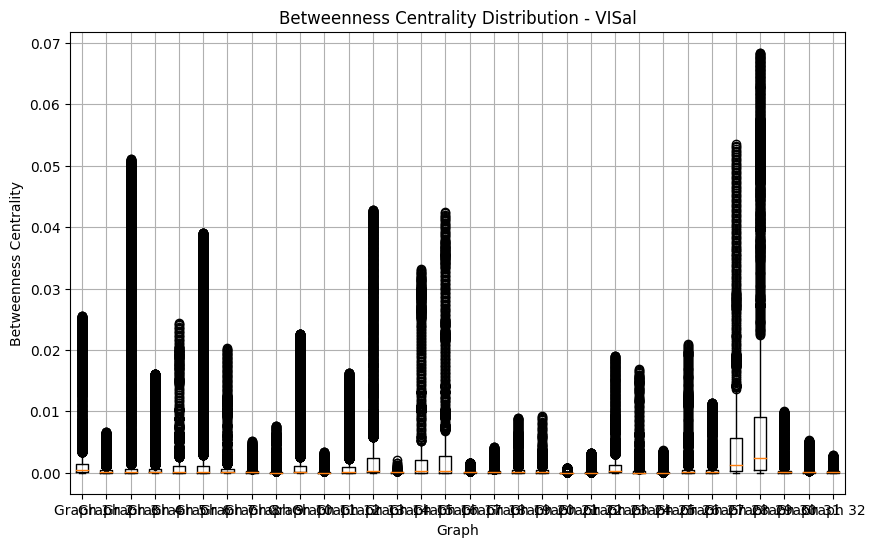

Summary statistics for SSp_bfd:
               Mean   Std Dev    Median
Graph 1    0.000759  0.002635  0.000086
Graph 2    0.003485  0.007615  0.000231
Graph 3    0.000053  0.000264  0.000006
Graph 4    0.000175  0.000850  0.000011
Graph 5    0.000708  0.002804  0.000034
...             ...       ...       ...
Graph 106  0.000156  0.000387  0.000030
Graph 107  0.000045  0.000114  0.000012
Graph 108  0.000136  0.000352  0.000027
Graph 109  0.002851  0.006258  0.000373
Graph 110  0.000066  0.000141  0.000023

[110 rows x 3 columns]


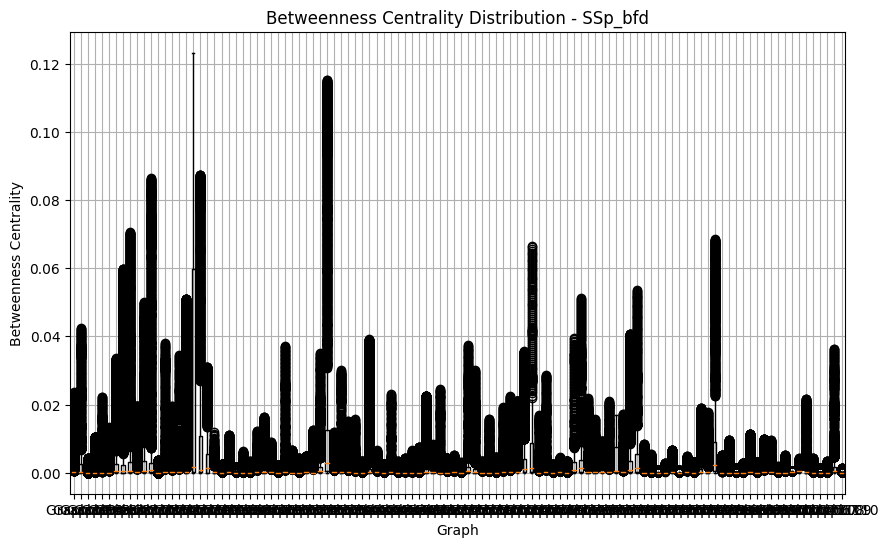

In [ ]:
# Analizzare la betweenness per ciascuna area
analyze_betweenness(VISp_betweenness, 'VISp')
analyze_betweenness(VISal_betweenness, 'VISal')
analyze_betweenness(SSp_bfd_betweenness, 'SSp_bfd')

In [ ]:
# Eseguire il t-test tra VISp e VISal
t_statistic_VISp_VISal, p_value_VISp_VISal = ttest_ind(VISp_betweenness, VISal_betweenness)
print(f"T-test VISp vs VISal: t-statistic = {t_statistic_VISp_VISal} , p-value = {p_value_VISp_VISal}")

# Eseguire il t-test tra VISp e SSp_bfd
t_statistic_VISp_SSp_bfd, p_value_VISp_SSp_bfd = ttest_ind(VISp_betweenness, SSp_bfd_betweenness)
print(f"T-test VISp vs SSp_bfd: t-statistic = {t_statistic_VISp_SSp_bfd} , p-value = {p_value_VISp_SSp_bfd}")

# Eseguire il t-test tra VISal e SSp_bfd
t_statistic_VISal_SSp_bfd, p_value_VISal_SSp_bfd = ttest_ind(VISal_betweenness, SSp_bfd_betweenness)
print(f"T-test VISal vs SSp_bfd: t-statistic = {t_statistic_VISal_SSp_bfd} , p-value = {p_value_VISal_SSp_bfd}")

# Eseguire il KS-test tra VISp e VISal
ks_statistic_VISp_VISal, ks_p_value_VISp_VISal = ks_2samp(VISp_betweenness, VISal_betweenness)
print(f"KS-test VISp vs VISal: ks-statistic = {ks_statistic_VISp_VISal} , p-value = {ks_p_value_VISp_VISal}")

# Eseguire il KS-test tra VISp e SSp_bfd
ks_statistic_VISp_SSp_bfd, ks_p_value_VISp_SSp_bfd = ks_2samp(VISp_betweenness, SSp_bfd_betweenness)
print(f"KS-test VISp vs SSp_bfd: ks-statistic = {ks_statistic_VISp_SSp_bfd} , p-value = {ks_p_value_VISp_SSp_bfd}")

# Eseguire il KS-test tra VISal e SSp_bfd
ks_statistic_VISal_SSp_bfd, ks_p_value_VISal_SSp_bfd = ks_2samp(VISal_betweenness, SSp_bfd_betweenness)
print(f"KS-test VISal vs SSp_bfd: ks-statistic = {ks_statistic_VISal_SSp_bfd} , p-value = {ks_p_value_VISal_SSp_bfd}")

TypeError: unsupported operand type(s) for +: 'dict' and 'dict'